<a href="https://colab.research.google.com/github/analiacuracaram/OlivIA/blob/main/OlivIA_Seminario_de_trabajo_final_(25_06).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introducción

**Resumen**
Este trabajo final propone el desarrollo de un modelo de redes neuronales convolucionales entrenado con imágenes locales de hojas de olivo, con el objetivo de ofrecer una solución accesible, precisa y aplicable sin conexión, pensada para apoyar a productores en contextos rurales y de bajos recursos.

**Problemática observada**
La detección temprana de enfermedades en olivos es crucial para evitar pérdidas económicas, especialmente en pequeñas explotaciones agrícolas. Sin embargo, las herramientas existentes no están especializadas en este cultivo, requieren conexión a internet estable y no consideran las condiciones locales.

**Hipótesis de Investigación**
“Es posible detectar enfermedades y plagas en árboles de olivo, específicamente en la hoja y mediante el análisis de imágenes capturadas con dispositivos comunes como son los teléfonos móviles de los productores de la zona”.


###Importación de librerías y montaje de drive

In [ ]:
import cv2
import os
import numpy as np
from glob import glob

In [ ]:
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rembg onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.4 MB/s eta 0:00:00


In [ ]:
from rembg import remove

ModuleNotFoundError: No module named 'rembg'

In [ ]:
from IPython.display import display
import os
from PIL import Image
import io
import shutil
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow scikit-learn matplotlib

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Limpieza y preparación de los datos

In [ ]:
#Punto de partida con las imágenes capturadas por mí en el campo 341 + 53 de olivos turcos para completar la clase desbalanceada (repilo)
folder_path = '/content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/Originales'

##Data Augmentation

In [ ]:
source_folder = '/content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/Originales'
augmented_folder = '/content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/SClasificarDataAugmentation'
os.makedirs(augmented_folder, exist_ok=True)

In [ ]:
# Extensiones de imagen válidas
extensiones = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

contador = 0
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith(extensiones):
            contador += 1

print(f"🔢 Total de imágenes encontradas (incluyendo subcarpetas): {contador}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔢 Total de imágenes encontradas (incluyendo subcarpetas): 394


In [ ]:
#Funciones de augmentación que hacen diversas modificaciones y generan copias de la imagen original
 #(rotar, zoom, flip, ajustar brillo, etc)
def rotate_image(img, angle):
    h, w = img.shape[:2]
    center = (w//2, h//2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, matrix, (w, h))

def flip_image(img, mode):
    return cv2.flip(img, mode)

def zoom_image(img, zoom_factor=1.2):
    h, w = img.shape[:2]
    new_h, new_w = int(h/zoom_factor), int(w/zoom_factor)
    top = (h - new_h) // 2
    left = (w - new_w) // 2
    zoomed = img[top:top+new_h, left:left+new_w]
    return cv2.resize(zoomed, (w, h))

def adjust_brightness(img, factor=1.2):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 2] *= factor
    hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

def translate_image(img, x_shift, y_shift):
    h, w = img.shape[:2]
    matrix = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    return cv2.warpAffine(img, matrix, (w, h))

#Procesar cada imagen
image_paths = glob(os.path.join(source_folder, '*'))

for path in image_paths:
    filename = os.path.basename(path)
    name, ext = os.path.splitext(filename)

    img = cv2.imread(path)
    if img is None:
        continue

    #Guardar original
    cv2.imwrite(os.path.join(augmented_folder, f"{name}_original{ext}"), img)

    # #Rotar
    # cv2.imwrite(os.path.join(augmented_folder, f"{name}_rot15{ext}"), rotate_image(img, 15))
    # cv2.imwrite(os.path.join(augmented_folder, f"{name}_rot-15{ext}"), rotate_image(img, -15)) #lo quité porque me pareció que no aportaba esta transformación

    #Flips
    cv2.imwrite(os.path.join(augmented_folder, f"{name}_flipH{ext}"), flip_image(img, 1))
    cv2.imwrite(os.path.join(augmented_folder, f"{name}_flipV{ext}"), flip_image(img, 0))

    #Zoom
    cv2.imwrite(os.path.join(augmented_folder, f"{name}_zoom{ext}"), zoom_image(img, 1.3))

    #Brillo
    cv2.imwrite(os.path.join(augmented_folder, f"{name}_bright{ext}"), adjust_brightness(img, 1.4))
    cv2.imwrite(os.path.join(augmented_folder, f"{name}_dark{ext}"), adjust_brightness(img, 0.6))

    #Traslaciones
    cv2.imwrite(os.path.join(augmented_folder, f"{name}_moveR{ext}"), translate_image(img, 20, 0))
    cv2.imwrite(os.path.join(augmented_folder, f"{name}_moveD{ext}"), translate_image(img, 0, 20))

print("✅ Data augmentation terminado.")

✅ Data augmentation terminado.


In [ ]:
folder_path = '/content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/SClasificarDataAugmentation'

# Extensiones de imagen válidas
extensiones = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

contador = 0
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith(extensiones):
            contador += 1

print(f"🔢 Total de imágenes encontradas (incluyendo subcarpetas): {contador}")


🔢 Total de imágenes encontradas (incluyendo subcarpetas): 3152


##Limpieza de fondo

In [ ]:
#Definir las rutas de las carpetas usando el path
sinfondo_path = '/content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/SinFondo'

In [ ]:
#Verifico que las encuentre y crea homóloga en colab
if os.path.exists(augmented_folder):
    print(f'✅ Carpeta de entrada encontrada: {augmented_folder}')
else:
    print(f'❌ Carpeta de entrada NO encontrada: {augmented_folder}')

if os.path.exists(sinfondo_path):
    print(f'✅ Carpeta de salida encontrada: {sinfondo_path}')
else:
    print(f'❌ Carpeta de salida NO encontrada: {sinfondo_path}')

✅ Carpeta de entrada encontrada: /content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/SClasificarDataAugmentation
✅ Carpeta de salida encontrada: /content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/SinFondo


In [ ]:
#Iterar sobre las imagenes de la carpeta de entrada
for filename in os.listdir(augmented_folder):
    if filename.lower().endswith(('.jpg')): #Procesar solo archivos de imagen y tengo jpg
        print(f"Procesando: {filename}")
        input_path = os.path.join(augmented_folder, filename)

        try:
            #Abrir la imagen
            with Image.open(input_path) as img:
                #Eliminar fondo
                output_data = remove(img)

                #Guardar resultado en la carpeta de salida de Drive
                output_filename = f"{os.path.splitext(filename)[0]}_sin_fondo.png"
                output_path = os.path.join(sinfondo_path, output_filename)
                output_data.save(output_path)
                print(f"Guardado: {output_path}")

        except Exception as e:
            print(f"Error procesando {filename}: {e}")

print("✅ Todas las imágenes han sido procesadas.")

Procesando: 1746126232491_original.jpg


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 169GB/s]


Guardado: /content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/SinFondo/1746126232491_original_sin_fondo.png
Procesando: 1746126232491_flipH.jpg
Guardado: /content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/SinFondo/1746126232491_flipH_sin_fondo.png
Procesando: 1746126232491_flipV.jpg
Guardado: /content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/SinFondo/1746126232491_flipV_sin_fondo.png
Procesando: 1746126232491_zoom.jpg
Guardado: /content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/SinFondo/1746126232491_zoom_sin_fondo.png
Procesando: 1746126232491_bright.jpg
Guardado: /content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/SinFondo/1746126232491_bright_sin_fondo.png
Procesando: 1746126232491_dark.jpg
Guardado: /content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/SinFondo/1746126232491_dark_sin_fondo.png
Procesando: 1746126232491_moveR.jpg
Guardado: /content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/SinFond

KeyboardInterrupt: 

In [ ]:
cant_imagenes = [f for f in os.listdir(sinfondo_path) if f.lower().endswith('.png')]
print(f"Quedaron {len(cant_imagenes)} imágenes en la carpeta.")

Quedaron 2928 imágenes en la carpeta.


## Descarte de imágenes

In [ ]:
def empty_image(path, umbral_opacidad = 10):
    img = Image.open(path).convert("RGBA")
    alpha = img.split()[-1]
    # Promedio del canal alpha (transparencia): 0 = totalmente transparente, 255 = opaca
    media_alpha = alpha.getdata()
    avg = sum(media_alpha) / len(media_alpha)
    return avg < umbral_opacidad

for file_ in os.listdir(sinfondo_path):
    if file_.endswith(('.png')):
        path = os.path.join(sinfondo_path, file_)
        try:
            if empty_image(path):
                print(f"Eliminando imagen vacía: {file_}")
                os.remove(path)
        except Exception as e:
            print(f"Error con {file_}: {e}")
print("✅ Todas las imágenes han sido procesadas.")

Eliminando imagen vacía: 1746126232636_original_sin_fondo.png
Eliminando imagen vacía: 1746126232636_flipH_sin_fondo.png
Eliminando imagen vacía: 1746126232636_flipV_sin_fondo.png
Eliminando imagen vacía: 1746126232636_bright_sin_fondo.png
Eliminando imagen vacía: 1746126232818_flipH_sin_fondo.png
Eliminando imagen vacía: 1746126233032_flipH_sin_fondo.png
Eliminando imagen vacía: 1746126233032_flipV_sin_fondo.png
Eliminando imagen vacía: 1746126231549_flipH_sin_fondo.png
Eliminando imagen vacía: 1746126231549_bright_sin_fondo.png
Eliminando imagen vacía: 1746126231641_dark_sin_fondo.png
Eliminando imagen vacía: 1746126231641_moveD_sin_fondo.png
Eliminando imagen vacía: 1746126231781_flipH_sin_fondo.png
Eliminando imagen vacía: 1746126231781_zoom_sin_fondo.png
Eliminando imagen vacía: 1746126231798_zoom_sin_fondo.png
Eliminando imagen vacía: 1746126231798_bright_sin_fondo.png
Eliminando imagen vacía: 1746126231849_original_sin_fondo.png
Eliminando imagen vacía: 1746126231849_zoom_sin_fo

In [ ]:
imagenes_restantes = [f for f in os.listdir(sinfondo_path) if f.lower().endswith('.png')]
print(f"Quedaron {len(imagenes_restantes)} imágenes en la carpeta.")

Quedaron 2928 imágenes en la carpeta.


##Clusterización

In [ ]:
sinfondo_path = '/content/drive/MyDrive/Facu UGR/2025/Seminario de trabajo final/SinFondo'

In [ ]:
img_size = (224, 224)
k = 2

# Cargar modelo
modelo = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# Obtener vectores de características
imagenes = []
vectores = []

for archivo in os.listdir(sinfondo_path):
    if archivo.lower().endswith((".png")):
        ruta_img = os.path.join(sinfondo_path, archivo)
        img = image.load_img(ruta_img, target_size=img_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        emb = modelo.predict(x).flatten()
        vectores.append(emb)
        imagenes.append(archivo)

vectores = np.array(vectores)

# Aplicar KMeans sobre los vectores
kmeans = KMeans(n_clusters=k, random_state=42)
etiquetas = kmeans.fit_predict(vectores)

In [ ]:
#Crear carpetas por clases
for archivo, etiqueta in zip(imagenes, etiquetas):
    origen = os.path.join(sinfondo_path, archivo)
    destino_cluster = os.path.join(sinfondo_path, f"cluster_{etiqueta}")
    os.makedirs(destino_cluster, exist_ok=True)
    shutil.copy(origen, os.path.join(destino_cluster, archivo))

print(f"✓ Se agruparon {len(imagenes)} imágenes en {k} clusters.")

✓ Se agruparon 2928 imágenes en 2 clusters.


In [ ]:
conteo_clusters = {}

# Recorre todas las subcarpetas (cada una representa un cluster)
for folder in os.listdir(sinfondo_path):
    path = os.path.join(sinfondo_path, folder)
    if os.path.isdir(path):
        cantidad = len([
            f for f in os.listdir(path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        conteo_clusters[folder] = cantidad

# Mostrar el resultado
for cluster, cantidad in sorted(conteo_clusters.items()):
    print(f"{cluster}: {cantidad} imágenes")

# Total (opcional)
print(f"\nTotal: {sum(conteo_clusters.values())} imágenes")


cluster_0: 1729 imágenes
cluster_1: 1898 imágenes

Total: 3627 imágenes


#Entrenamiento

##Split y preparación de los datos para el entrenamiento

In [ ]:

img_size = (224, 224) #tamaño estandard para este modelo (fueron entrenadas con este tamaño)
batch_size = 32 #Pruebo un batch size equilibrado

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,  # 75% entrenamiento, 25% validación
    #Simulo variaciones aleatorias en las imagenes para evitar overfitting
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.1
)

train_gen = train_datagen.flow_from_directory( #aqui recorre las imagenes con la estructura de carpeta sin_fondo ->cluster_0/cluster_1
    sinfondo_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    sinfondo_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2721 images belonging to 2 classes.
Found 906 images belonging to 2 classes.


Ligero y eficiente:
Está diseñado para funcionar bien en dispositivos móviles o con pocos recursos

Preentrenado en ImageNet:
Ha aprendido a ver formas, texturas y patrones útiles, lo que permite aprovechar ese conocimiento para tareas nuevas (como detectar enfermedades en hojas de olivo).

Compatible con TensorFlow Lite:
Se puede exportar fácilmente para funcionar en apps móviles sin conexión.

Ideal para transfer learning:
Usa MobileNetV2 como extractor de características y entrena con parámetros personalizados con las clases de este proyecto.


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))#include_top=False descarto los parámetros por default para que solo clasifique 2 clases
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),# Evita overfitting
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # 2 clases
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5938 - loss: 0.7008

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 717s 8s/step - accuracy: 0.5950 - loss: 0.6993 - val_accuracy: 0.8731 - val_loss: 0.3510
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.8391 - loss: 0.3909 - val_accuracy: 0.9040 - val_loss: 0.2742
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - accuracy: 0.8920 - loss: 0.2768 - val_accuracy: 0.9139 - val_loss: 0.2481
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.8972 - loss: 0.2584 - val_accuracy: 0.9327 - val_loss: 0.2089
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 344s 4s/step - accuracy: 0.9228 - loss: 0.2192 - val_accuracy: 0.9260 - val_loss: 0.1988
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - accuracy: 0.9208 - loss: 0.2079 - val_accuracy: 0.9260 - val_loss: 0.2042
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - accuracy: 0.9329 - loss: 0.1731 - val_accuracy: 0.9040 - val_loss: 0.2461
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.9332 - loss: 0.1771 - val_accuracy: 0.9260 - val_loss: 0.

#Evaluación

In [ ]:
# history es el objeto devuelto por model.fit()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print("Promedio de métricas por época:")
print(f"Entrenamiento - Accuracy promedio:     {np.mean(acc):.4f}")
print(f"Entrenamiento - Loss promedio:         {np.mean(loss):.4f}")
print(f"Validación    - Accuracy promedio:     {np.mean(val_acc):.4f}")
print(f"Validación    - Loss promedio:         {np.mean(val_loss):.4f}")


Promedio de métricas por época:
Entrenamiento - Accuracy promedio:     0.8950
Entrenamiento - Loss promedio:         0.2538
Validación    - Accuracy promedio:     0.9125
Validación    - Loss promedio:         0.2350


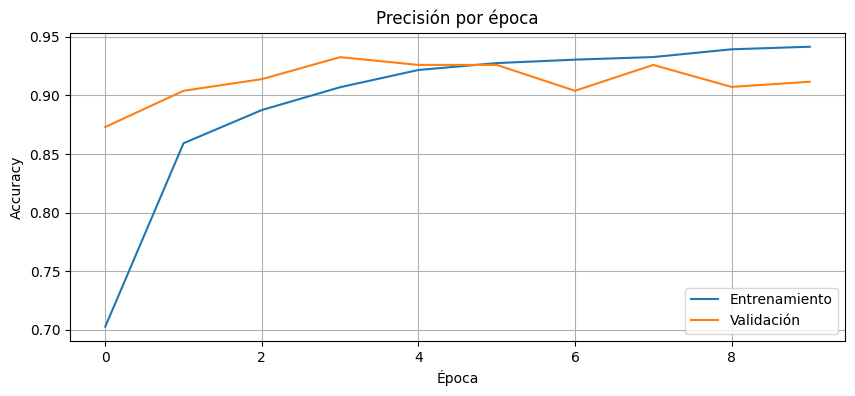

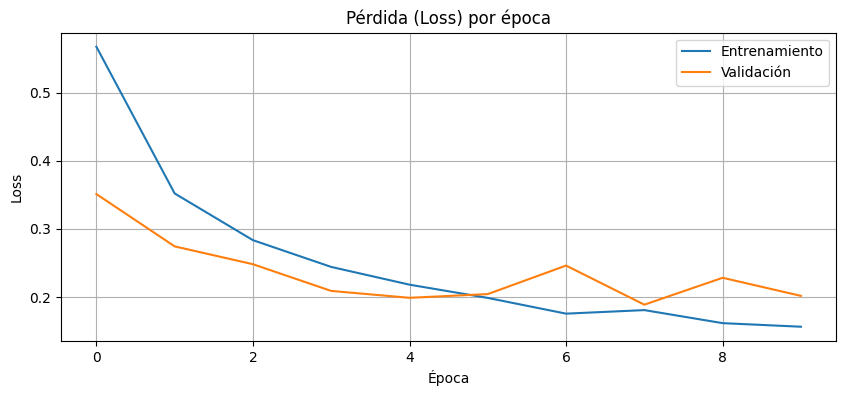

In [ ]:
#Accuracy

plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss) por época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step


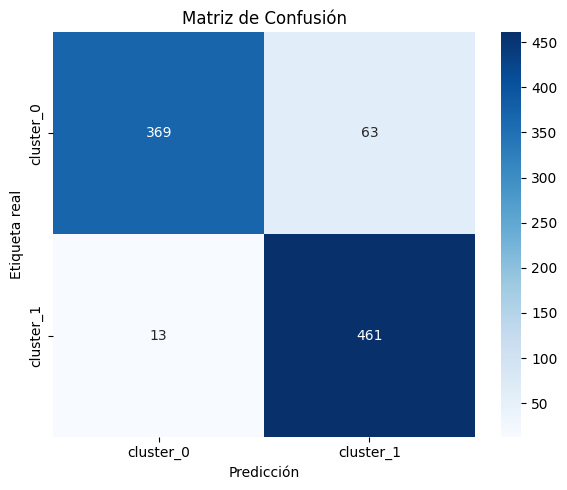

📊 Métricas de evaluación por clase:

              precision    recall  f1-score   support

   cluster_0       0.97      0.85      0.91       432
   cluster_1       0.88      0.97      0.92       474

    accuracy                           0.92       906
   macro avg       0.92      0.91      0.92       906
weighted avg       0.92      0.92      0.92       906



In [ ]:
y_true = val_gen.classes
y_pred = model.predict(val_gen,verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Nombres de las clases (según carpeta)
class_names = list(val_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

# Métricas por clase
print("📊 Métricas de evaluación por clase:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/tmp/ipython-input-21-1829694007.py:17: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


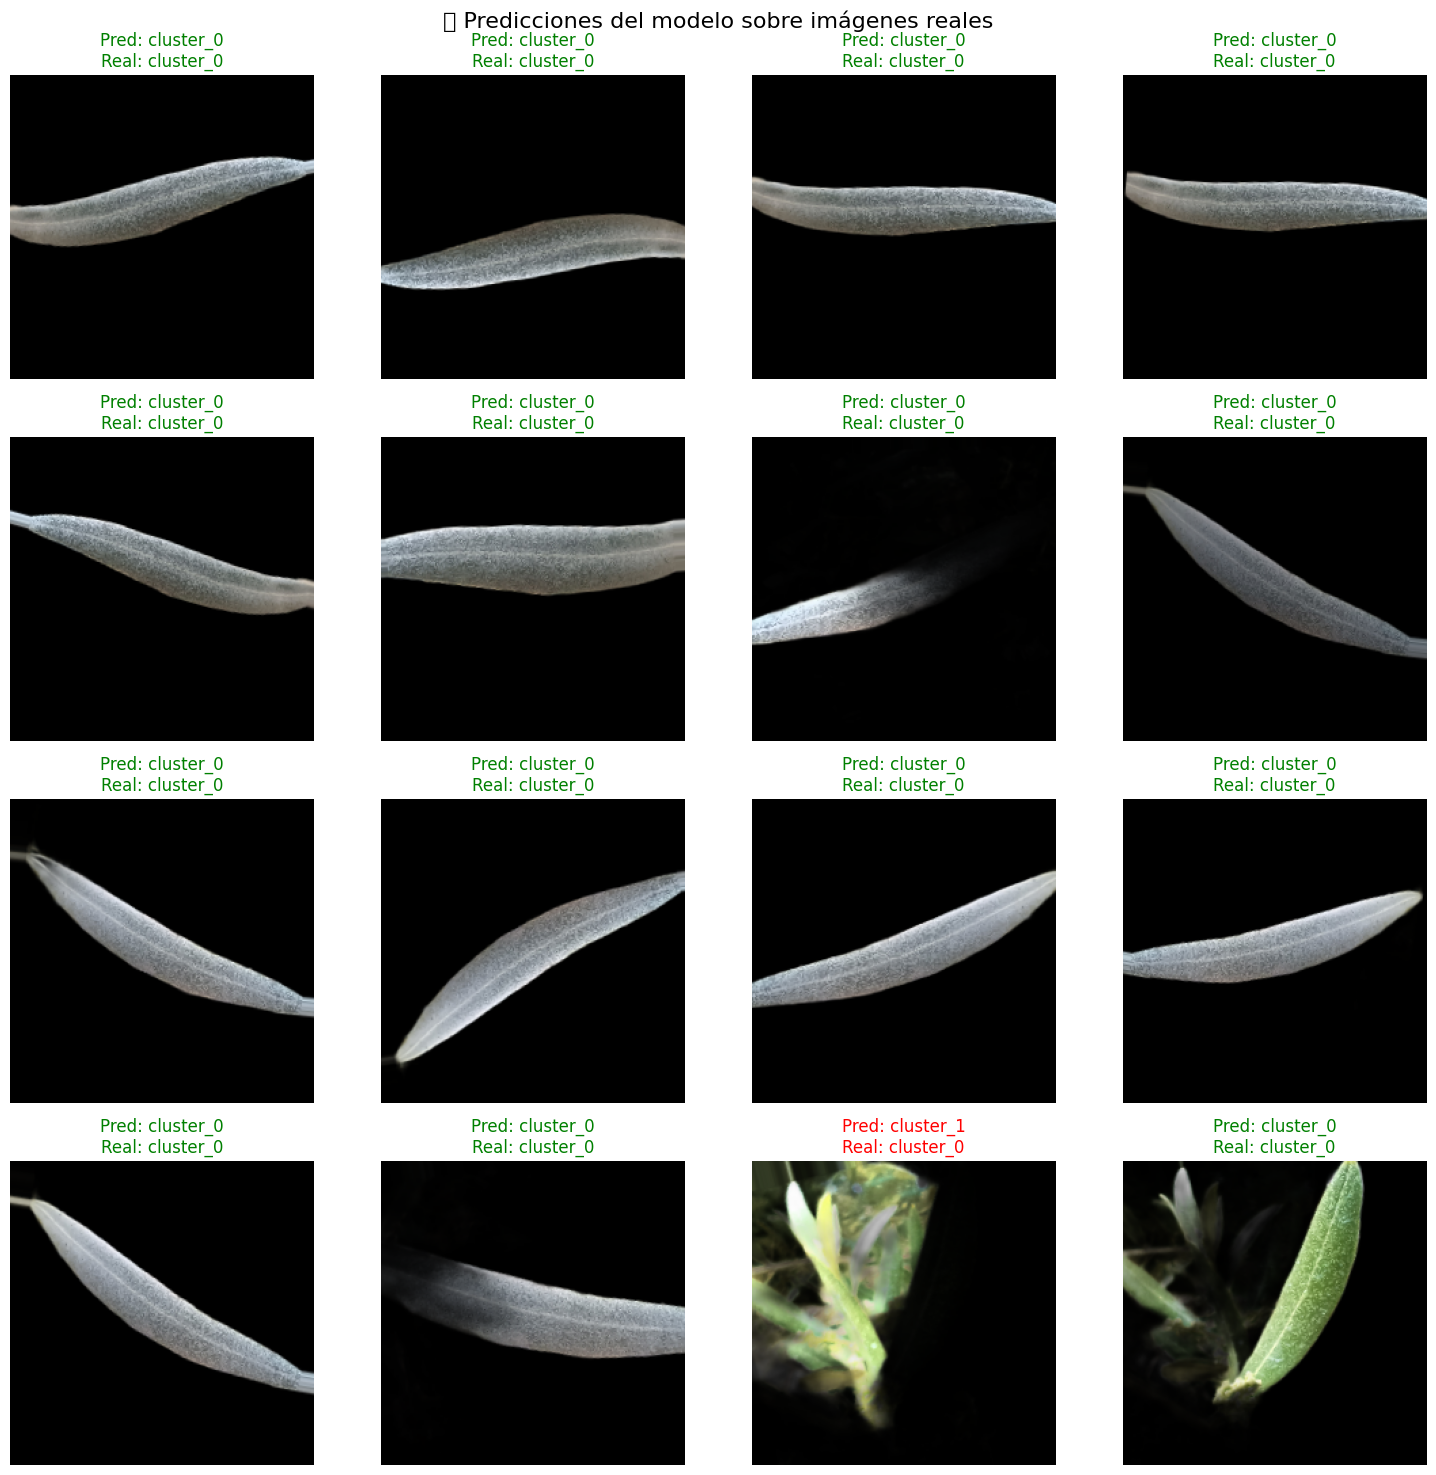

In [ ]:
x, y = next(val_gen)
y_pred = model.predict(x)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y, axis=1)

plt.figure(figsize=(15, 15)) # Aumentar el tamaño de la figura para más subplots
for i in range(16):  # Muestra 16 imágenes
    plt.subplot(4, 4, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    pred = class_names[y_pred_labels[i]]
    real = class_names[y_true_labels[i]]
    color = 'green' if pred == real else 'red'
    plt.title(f'Pred: {pred}\nReal: {real}', color=color)

plt.suptitle("🔍 Predicciones del modelo sobre imágenes reales", fontsize=16)
plt.tight_layout()
plt.show()